## 1. Data Preparation for Machine Learning Model

In [1]:
import pandas as pd
import numpy as np
import datetime

In [2]:
def load_data():
    Transactions= pd.read_excel("KPMG_VI_New_raw_data_update_final.xlsx", sheet_name= "Transactions")
    NewCustomerList= pd.read_excel("KPMG_VI_New_raw_data_update_final.xlsx", sheet_name= "NewCustomerList")
    CustomerDemographic= pd.read_excel("KPMG_VI_New_raw_data_update_final.xlsx", sheet_name= "CustomerDemographic")
    CustomerAddress= pd.read_excel("KPMG_VI_New_raw_data_update_final.xlsx", sheet_name= "CustomerAddress")
    return (Transactions, NewCustomerList, CustomerDemographic, CustomerAddress)

In [3]:
def cleanup_header(df):
    new_header= df.iloc[0]
    df = df[1:]
    df.columns= new_header
    return df

In [4]:
def merge_customer_list(CustomerDemographic, CustomerAddress):
    CustomerDemographic.set_index("customer_id", inplace=True)
    CustomerAddress.set_index("customer_id", inplace=True)
    return CustomerDemographic.join(CustomerAddress, on="customer_id")

In [5]:
def keep_common_columns(CustomerList, NewCustomerList):
    common_col_set = set(np.intersect1d(NewCustomerList.columns, CustomerList.columns))
    drop_customer_cols = set(CustomerList.columns.to_numpy()) - common_col_set
    drop_new_customer_cols = set(NewCustomerList.columns.to_numpy()) - common_col_set
    CustomerList.drop(columns=drop_customer_cols, inplace=True)
    NewCustomerList.drop(columns=drop_new_customer_cols, inplace=True)
    return (CustomerList, NewCustomerList)

In [6]:
def col_category_to_idx(df, col):   
    l = df[col].unique()
    d = {k: v for v, k in enumerate(l)}
    df[col].replace(d, inplace= True)

In [7]:
def cleanup_customer(df):
    df.drop(columns=["first_name", "last_name", "job_title", 
                     "deceased_indicator", "address", "postcode", "country"], inplace=True)
    # Gender
    genderDict = {"F": "Female", "M": "Male", "Femal": "Female", "U": "Undefined"}
    df['gender'].replace(genderDict, inplace= True)
    col_category_to_idx(df, "gender")
    
    # DOB
    now = datetime.datetime.now()
    df['age']= now.year - pd.DatetimeIndex(df['DOB']).year
    df.drop(columns=["DOB"], inplace=True)
    
    # Job industry category
    df["job_industry_category"].fillna("n/a", inplace=True)
    col_category_to_idx(df, "job_industry_category")
    
    col_category_to_idx(df, "wealth_segment")
    col_category_to_idx(df, "owns_car")  
    
    # tenure
    df["tenure"].fillna(df["tenure"].mean(), inplace=True)
    
    # state
    stateDict = {"New South Wales": "NSW", "Victoria": "VIC", "Queensland": "QLD"}
    df['state'].replace(stateDict, inplace= True)
    df["state"].fillna("n/a", inplace=True)
    col_category_to_idx(df, "state")  
    
    # property valuation
    df["property_valuation"] = df["property_valuation"].astype("float64")
    df["property_valuation"].fillna(df["property_valuation"].mean(), inplace=True)
    
    # age
    df["age"].fillna(df["age"].mean(), inplace=True)
    
    # Or rename the existing DataFrame (rather than creating a copy) 
    df.rename(columns={'past_3_years_bike_related_purchases': '3y_bike'}, inplace=True)
    df["3y_bike"] = df["3y_bike"].astype("float64")
    

In [8]:
def customer_score(tr):
    tr = tr[["customer_id", "list_price", "standard_cost"]]
    tr = tr.dropna(how="any")
    tr["score"] = tr["list_price"] #- tr["standard_cost"]
    tr = tr[["customer_id", "score"]]
    tr = tr.groupby(['customer_id'])['score'].sum().reset_index()
    tr = tr.set_index("customer_id")
    return tr

In [9]:
def customer_features(df):
    # expand category data to one-hot vectors
    return pd.get_dummies(df, columns=["gender", "job_industry_category", 
                                       "wealth_segment", "owns_car", "state"])

In [10]:
def prepare_data():
    (Transactions, NewCustomerList, CustomerDemographic, CustomerAddress) = load_data()
    Transactions = cleanup_header(Transactions)
    NewCustomerList = cleanup_header(NewCustomerList)
    CustomerDemographic = cleanup_header(CustomerDemographic)
    CustomerAddress = cleanup_header(CustomerAddress)
    CustomerList = merge_customer_list(CustomerDemographic, CustomerAddress)
    # there are some columns that are nan
    NewCustomerList.columns = NewCustomerList.columns.fillna("n/a")

    (CustomerList, NewCustomerList) = keep_common_columns(CustomerList, NewCustomerList)

    CustomerListFeatures = CustomerList.copy()
    cleanup_customer(CustomerListFeatures)
    CustomerListFeatures = customer_features(CustomerListFeatures)
    CustomerScore = customer_score(Transactions)

    CustomersWithScore = CustomerListFeatures.join(CustomerScore, on="customer_id")
    CustomersWithScore.fillna(0, inplace=True)
    #CustomersWithScore = CustomersWithScore.sample(frac=1, random_state=1996)

    NewCustomerFeatures = NewCustomerList.copy()
    cleanup_customer(NewCustomerFeatures)
    NewCustomerFeatures = customer_features(NewCustomerFeatures)
    
    return (CustomersWithScore, NewCustomerFeatures, NewCustomerList)

In [11]:
(CustomersWithScore, NewCustomerFeatures, NewCustomerList) = prepare_data()

In [12]:
def to_inputs_outputs(data):
    X = np.delete(data, -1, axis=1)
    Y = data[:, -1].reshape((-1, 1))
    return (X, Y)

### Note: I dropped some features trying to improve Machine Learning Model

In [24]:
### trying this out
CustomersWithScore.columns
CustomersWithScoreReduced = CustomersWithScore.drop(columns=['job_industry_category_0','job_industry_category_1', 'job_industry_category_2',
       'job_industry_category_3', 'job_industry_category_4',
       'job_industry_category_5', 'job_industry_category_6',
       'job_industry_category_7', 'job_industry_category_8',
       'job_industry_category_9'])
CustomersWithScoreReduced = CustomersWithScoreReduced[["3y_bike", "tenure", "age", "score"]]
#CustomersWithScore.sample(5)

In [25]:
# convert to numpy array
data = CustomersWithScoreReduced.to_numpy()
data_train, data_dev, data_test = np.split(data, [int(0.8 * len(data)), int(0.95*len(data))])

X_train, Y_train = to_inputs_outputs(data_train)
X_dev, Y_dev = to_inputs_outputs(data_dev)
X_test, Y_test = to_inputs_outputs(data_test)

print("X_train", X_train.shape)
print("Y_train", Y_train.shape)
print("X_dev", X_dev.shape)
print("Y_dev", Y_dev.shape)
print("X_test", X_test.shape)
print("Y_test", Y_test.shape)

X_train (3200, 3)
Y_train (3200, 1)
X_dev (600, 3)
Y_dev (600, 1)
X_test (200, 3)
Y_test (200, 1)


### Note: Final Data prepared which was passed into ML model

In [26]:
#X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=245)
CustomersWithScoreReduced.head()

,3y_bike,tenure,age,score
customer_id,,,,
1,93.0,11.0,67.0,9084.45
2,81.0,16.0,40.0,4149.07
3,61.0,15.0,66.0,9888.23
4,33.0,7.0,59.0,1047.72
5,56.0,8.0,43.0,5903.20


## 2. Train Model with Keras

### Input features: 3, Output: 1 (Score = Total Customer Spendings)

In [18]:
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
 
model = Sequential()
model.add(Dense(1, activation='linear', input_shape=(3,)))
model.compile(optimizer=optimizers.RMSprop(lr=0.1), loss='mean_squared_error', metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 4         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.fit(X_train,Y_train,epochs=2000,batch_size=32,verbose=1,validation_data=(X_dev, Y_dev))

Epoch 1/2000
100/100 [==============================] - 0s 4ms/step - loss: 40886404.0000 - mae: 5669.4067 - val_loss: 17750928.0000 - val_mae: 3129.4951
Epoch 2/2000
100/100 [==============================] - 0s 2ms/step - loss: 30729474.0000 - mae: 4715.9194 - val_loss: 15214845.0000 - val_mae: 3206.1738
Epoch 3/2000
100/100 [==============================] - 0s 2ms/step - loss: 22855930.0000 - mae: 3882.4275 - val_loss: 14889909.0000 - val_mae: 3332.8716
Epoch 4/2000
100/100 [==============================] - 0s 3ms/step - loss: 17250684.0000 - mae: 3257.6877 - val_loss: 16651559.0000 - val_mae: 3576.7117
Epoch 5/2000
100/100 [==============================] - 0s 2ms/step - loss: 13820364.0000 - mae: 2890.1306 - val_loss: 19924928.0000 - val_mae: 3883.0867
Epoch 6/2000
100/100 [==============================] - 0s 2ms/step - loss: 12388794.0000 - mae: 2762.9441 - val_loss: 22450236.0000 - val_mae: 4101.7676
Epoch 7/2000
100/100 [==============================] - 0s 2ms/step - loss: 

### Issue: "mae" stops at around 2350 and doesn't go down further

In [27]:
model.predict(X_train[:10])

array([[6777.249 ],
       [6222.5845],
       [6650.791 ],
       [6489.6685],
       [6253.0195],
       [6371.0723],
       [6119.924 ],
       [6465.9126],
       [6437.338 ],
       [5967.718 ]], dtype=float32)

In [35]:
Y_train[:10]

array([[ 9084.45],
       [ 4149.07],
       [ 9888.23],
       [ 1047.72],
       [ 5903.2 ],
       [ 5931.69],
       [  995.38],
       [12024.76],
       [ 5357.55],
       [ 5003.75]])

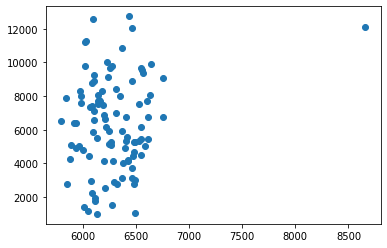

In [39]:
plt.scatter(model.predict(X_train[:100]), Y_train[:100])